In [1]:
import numpy as np
import awkward as ak
from pathlib import Path
import pandas as pd
from datetime import datetime, timedelta
import json
from zoneinfo import ZoneInfo

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable, get_cmap
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors

import xobjects as xo
import xtrack as xt
import xpart as xp
import xcoll as xc

# BPM class
Adding _build functions to only build the stuff once when called

In [6]:
from typing import Optional, Tuple, Union, Set, List
import re

class BPMBehavior(ak.Record):
    pass

class BPMCollectionBehavior(ak.Array):
    @property
    def full_index(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        return self._full_index
    
    @property
    def index(self):
        if not hasattr(self, '_index'):
            self._build_index()
        return self._index
    
    @property
    def bpms_hor(self):
        if not hasattr(self, '_bpms_hor'):
            self._build_bpms_hor()
        return self._bpms_hor
    
    @property
    def bpms_ver(self):
        if not hasattr(self, '_bpms_ver'):
            self._build_bpms_ver()
        return self._bpms_ver
    
    @property
    def hor_turn_position(self):
        if not hasattr(self, '_hor_pos'):
            self._build_hor_pos()
        return self._hor_pos
    
    @property
    def ver_turn_position(self):
        if not hasattr(self, '_ver_pos'):
            self._build_ver_pos()
        return self._ver_pos
    
    def _build_full_index(self):
        self._full_index = {}

        bpm_entries = []

        # Collect all BPMs with metadata
        for crate in self.fields:
            for i, bpm in enumerate(self[crate]['value']['channelNames'][0]):
                if bpm != 'SPARE':
                    split_bpm = bpm.split('.')
                    bpm_name = split_bpm[0].lower() + '.' + split_bpm[1]
                    plane = split_bpm[2]
                    position = self[crate]['value']['positions'][0][i]

                    bpm_entries.append({
                        'bpm_name': bpm_name,
                        'plane': plane,
                        'crate': crate,
                        'position': position
                    })

        # Sort BPMs by natural order (e.g., bpm.1, bpm.2, ..., bpm.10)
        def natural_key(entry):
            # Extract the numeric part of the BPM name for sorting
            match = re.search(r'(\d+)$', entry['bpm_name'])
            return int(match.group(1)) if match else entry['bpm_name']

        bpm_entries.sort(key=natural_key)

        # Build _full_index with sorted BPMs
        for idx, entry in enumerate(bpm_entries):
            name = entry['bpm_name']
            if name not in self._full_index:
                self._full_index[name] = {}
            self._full_index[name]['plane'] = entry['plane']
            self._full_index[name]['index'] = idx
            self._full_index[name]['crate'] = entry['crate']
            self._full_index[name]['positions'] = entry['position']
    
    def _build_index(self):
        self._index = {}
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        for i, bpm in enumerate(self._full_index):
            if bpm not in self._index:
                self._index[bpm] = i

    def _build_bpms_hor(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        bpms = [bpm for bpm in self._full_index if self._full_index[bpm]['plane'] == 'H']
        self._bpms_hor = ak.Array(sorted(bpms, key=lambda bpm: self._full_index[bpm]['index'])) #BPMs are sorted by index
    
    def _build_bpms_ver(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        bpms = [bpm for bpm in self._full_index if self._full_index[bpm]['plane'] == 'V']
        self._bpms_ver = ak.Array(sorted(bpms, key=lambda bpm: self._full_index[bpm]['index'])) #BPMs are sorted by index

    def _build_hor_pos(self):
        if not hasattr(self, '_bpms_hor'):
            self._build_bpms_hor()
        self._hor_pos = ak.Array([self._full_index[bpm]['positions'] for bpm in self._bpms_hor])
    
    def _build_ver_pos(self):
        if not hasattr(self, '_bpms_ver'):
            self._build_bpms_ver()
        self._ver_pos = ak.Array([self._full_index[bpm]['positions'] for bpm in self._bpms_ver])


ak.behavior["*", "BPMCollection"] = BPMCollectionBehavior

# Test loading specific files with parameters.json

In [7]:
df_params = pd.read_json('../../MD_data/20250616/parameters.json').T
df_params.index = pd.to_datetime(df_params.index) #convert index (string timestamp) to datetime
df_params.index = df_params.index.tz_localize("Europe/Paris") #Set to Geneva time

In [4]:
df_params.loc["2025-06-16 20:00:00":"2025-06-16 20:30:00"] #test getting specific range of parameters

NameError: name 'df_params' is not defined

In [8]:
directory = Path('/Users/lisepauwels/sps_simulations/MD_data/20250616/bpm/SPS.USER.MD2')
paths_files_list = list(directory.glob("*.parquet"))
path_files = {}
for path in paths_files_list:
    stem = path.stem
    dt = datetime.strptime(stem, "%Y.%m.%d.%H.%M.%S.%f")
    dt = dt.replace(tzinfo=ZoneInfo("Europe/Paris"))
    path_files[dt] = path
path_files = pd.DataFrame.from_dict(path_files, orient='index', columns=['path'])
path_files.index = pd.to_datetime(path_files.index)
print(path_files.index.is_monotonic_increasing)
path_files = path_files.sort_index() #Files need to be sorted by index for correct time series handling
print(path_files.index.is_monotonic_increasing)

False
True


In [9]:
selected_paths = path_files.loc["2025-06-16 20:03:15":"2025-06-16 20:04:11", "path"].to_numpy()
print(selected_paths)
print(type(selected_paths))

[PosixPath('/Users/lisepauwels/sps_simulations/MD_data/20250616/bpm/SPS.USER.MD2/2025.06.16.20.03.19.982107.parquet')
 PosixPath('/Users/lisepauwels/sps_simulations/MD_data/20250616/bpm/SPS.USER.MD2/2025.06.16.20.03.47.601017.parquet')]
<class 'numpy.ndarray'>


# Full overview
Is there at least a file per radial steering?

In [10]:
df_fo = pd.read_json('../../MD_data/20250616/full_overview.json').T
df_fo.index = pd.to_datetime(df_fo.index) #convert index (string timestamp) to datetime
df_fo.index = df_fo.index.tz_localize("Europe/Paris") #Set to Geneva time

In [11]:
ll = df_fo.loc["2025-06-16 20:04:11":"2025-06-16 20:05:33"].index.to_numpy()
lll = path_files.loc["2025-06-16 20:04:11":"2025-06-16 20:05:33", "path"].to_numpy()
print(ll)
print(lll)
# For first test, looks good, also with timestamps

[Timestamp('2025-06-16 20:04:11.900000+0200', tz='Europe/Paris')
 Timestamp('2025-06-16 20:04:39.500000+0200', tz='Europe/Paris')
 Timestamp('2025-06-16 20:05:07.100000+0200', tz='Europe/Paris')]
[PosixPath('/Users/lisepauwels/sps_simulations/MD_data/20250616/bpm/SPS.USER.MD2/2025.06.16.20.04.15.339607.parquet')
 PosixPath('/Users/lisepauwels/sps_simulations/MD_data/20250616/bpm/SPS.USER.MD2/2025.06.16.20.04.42.799813.parquet')
 PosixPath('/Users/lisepauwels/sps_simulations/MD_data/20250616/bpm/SPS.USER.MD2/2025.06.16.20.05.10.620176.parquet')]


In [12]:
changes_ts = df_params.index.to_numpy()
dt = timedelta(seconds=1)

for ts_start, ts_end in zip(changes_ts[:-1], changes_ts[1:]):
    ll = df_fo.loc[ts_start:ts_end-dt].index.to_numpy()
    lll = path_files.loc[ts_start:ts_end-dt, "path"].to_numpy()

    if len(ll) != len(lll):
        print(ll)
        print(lll)
        print(' ')
#There are more files than what we recorded, so actually more data than what we have in the overview

[Timestamp('2025-06-16 11:52:17.900000+0200', tz='Europe/Paris')
 Timestamp('2025-06-16 11:52:59.800000+0200', tz='Europe/Paris')
 Timestamp('2025-06-16 11:53:41.900000+0200', tz='Europe/Paris')
 Timestamp('2025-06-16 11:54:23.900000+0200', tz='Europe/Paris')
 Timestamp('2025-06-16 11:55:05.900000+0200', tz='Europe/Paris')]
[PosixPath('/Users/lisepauwels/sps_simulations/MD_data/20250616/bpm/SPS.USER.MD2/2025.06.16.11.52.20.858124.parquet')
 PosixPath('/Users/lisepauwels/sps_simulations/MD_data/20250616/bpm/SPS.USER.MD2/2025.06.16.11.53.02.735300.parquet')
 PosixPath('/Users/lisepauwels/sps_simulations/MD_data/20250616/bpm/SPS.USER.MD2/2025.06.16.11.53.44.841046.parquet')
 PosixPath('/Users/lisepauwels/sps_simulations/MD_data/20250616/bpm/SPS.USER.MD2/2025.06.16.11.54.26.760990.parquet')
 PosixPath('/Users/lisepauwels/sps_simulations/MD_data/20250616/bpm/SPS.USER.MD2/2025.06.16.11.55.08.830556.parquet')
 PosixPath('/Users/lisepauwels/sps_simulations/MD_data/20250616/bpm/SPS.USER.MD2/202

In [13]:
# Making new dict with paths per timestamp
paths_per_ts = {}
for ts_start, ts_end in zip(changes_ts[:-1], changes_ts[1:]):
    ll = df_fo.loc[ts_start:ts_end-dt].index.to_numpy()
    lll = path_files.loc[ts_start:ts_end-dt, "path"].to_numpy()
    
    for i in range(len(ll)):
        paths_per_ts[ll[i]] = lll[i]
paths_per_ts = pd.DataFrame.from_dict(paths_per_ts, orient='index', columns=['path'])

In [81]:
paths_per_ts

,path
2025-06-16 11:52:17.900000+02:00,/Users/lisepauwels/sps_simulations/MD_data/202...
2025-06-16 11:52:59.800000+02:00,/Users/lisepauwels/sps_simulations/MD_data/202...
2025-06-16 11:53:41.900000+02:00,/Users/lisepauwels/sps_simulations/MD_data/202...
2025-06-16 11:54:23.900000+02:00,/Users/lisepauwels/sps_simulations/MD_data/202...
2025-06-16 11:55:05.900000+02:00,/Users/lisepauwels/sps_simulations/MD_data/202...
...,...
2025-06-16 20:17:04.700000+02:00,/Users/lisepauwels/sps_simulations/MD_data/202...
2025-06-16 20:17:32.300000+02:00,/Users/lisepauwels/sps_simulations/MD_data/202...
2025-06-16 20:17:59.900000+02:00,/Users/lisepauwels/sps_simulations/MD_data/202...
2025-06-16 20:18:27.500000+02:00,/Users/lisepauwels/sps_simulations/MD_data/202...


# Analysis after 8pm
Because the orbit was supposedly corrected by Gianni, see if it is better

In [15]:
line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')
tt = line.get_table()
tw = line.twiss()
s_tidp = line.get_s_position('tidp.11434')

Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           


## Test with -10mm bump

In [16]:
selected_ts = paths_per_ts.loc["2025-06-16 20:04:11":"2025-06-16 20:05:33"].index.to_numpy()
selected_paths = paths_per_ts.loc["2025-06-16 20:04:11":"2025-06-16 20:05:33", "path"].to_numpy()

In [17]:
bpm_dict = {}
for i,path in enumerate(selected_paths):
    bpm_dict[selected_ts[i]] = ak.Array(ak.from_parquet(path), with_name="BPMCollection")

In [18]:
hor_turn_position = bpm_dict[selected_ts[0]].hor_turn_position
s_pos = line.get_s_position([f'{bpm}..0' for bpm in bpm_dict[selected_ts[0]].bpms_hor if f'{bpm}..0' in line.element_names])

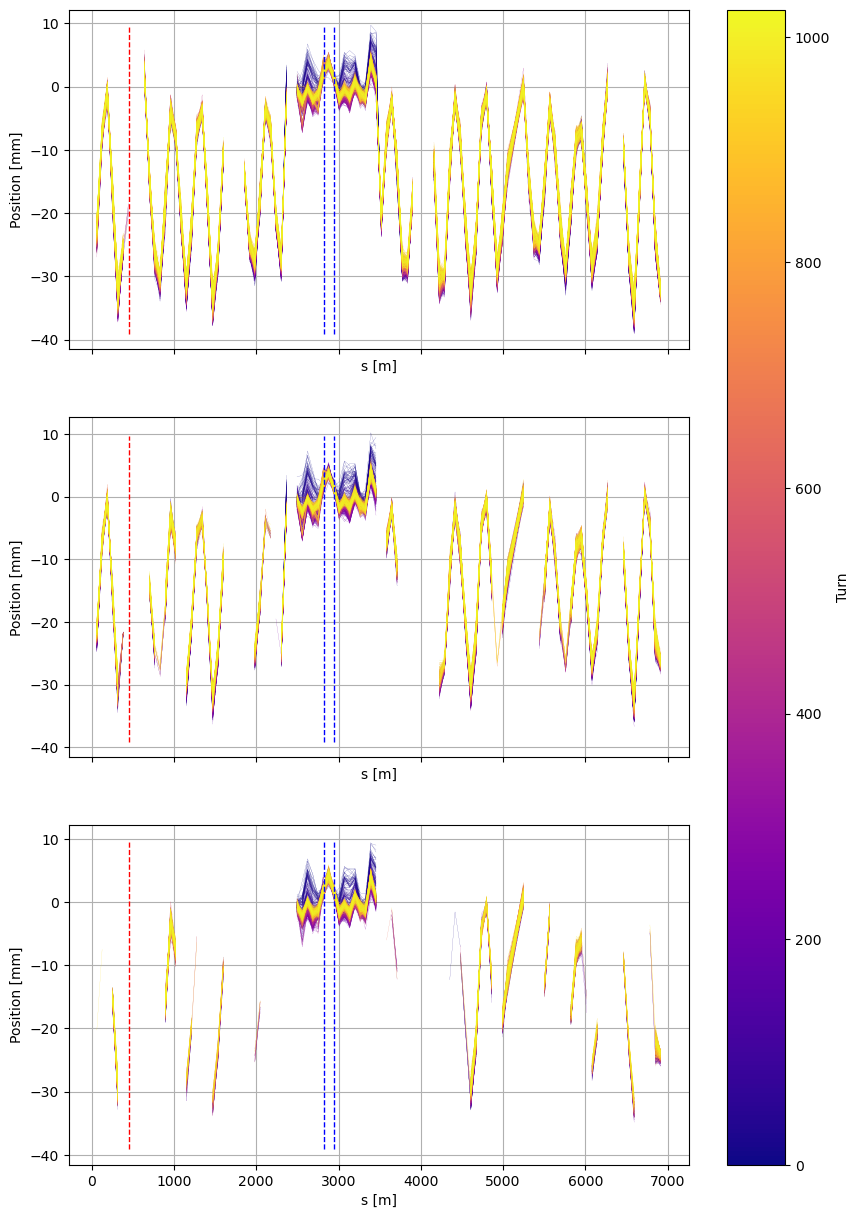

In [307]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
n_turns = 1024

cmap = plt.get_cmap('plasma', n_turns)
for i in range(len(hor_turn_position[0])):
    ax[0].plot(s_pos, bpm_dict[selected_ts[0]].hor_turn_position[:,i], lw=0.1, color=cmap(i))
    ax[1].plot(s_pos, bpm_dict[selected_ts[1]].hor_turn_position[:,i], lw=0.1, color=cmap(i))
    ax[2].plot(s_pos, bpm_dict[selected_ts[2]].hor_turn_position[:,i], lw=0.1, color=cmap(i))

for axis in ax:
    axis.set_xlabel("s [m]")
    axis.set_ylabel("Position [mm]")
    axis.grid()
    axis.vlines(s_tidp, np.min(bpm_dict[selected_ts[0]].hor_turn_position), np.max(bpm_dict[selected_ts[0]].hor_turn_position), 
                color='r', lw=1, ls='--')
    axis.vlines(np.min(tt.rows['.*act.*'].s_start),
                 np.min(bpm_dict[selected_ts[0]].hor_turn_position), np.max(bpm_dict[selected_ts[0]].hor_turn_position), 
                 color='b', lw=1, ls='--')
    axis.vlines(np.max(tt.rows['.*act.*'].s_end),
                 np.min(bpm_dict[selected_ts[0]].hor_turn_position), np.max(bpm_dict[selected_ts[0]].hor_turn_position), 
                 color='b', lw=1, ls='--')
norm = Normalize(vmin=0, vmax=n_turns)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add colorbar
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Turn")
plt.savefig('gianni_radial_steering_-10mm_bump.pdf', dpi=300)

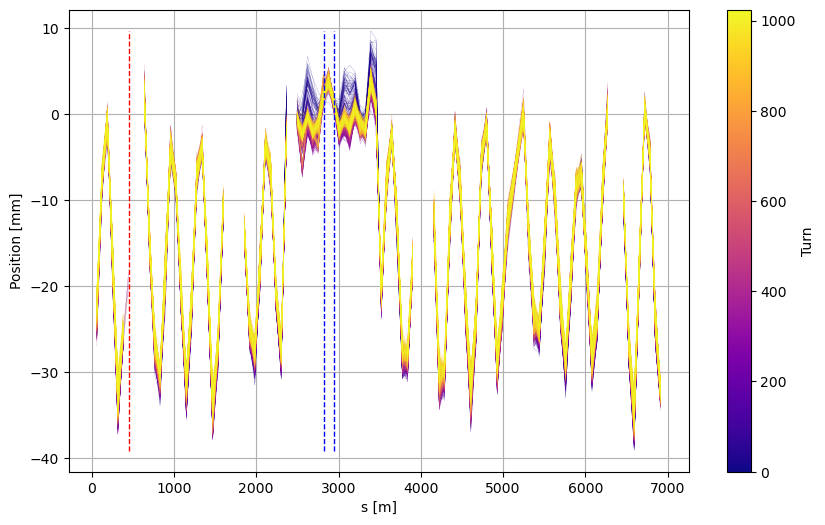

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
n_turns = 1024

cmap = plt.get_cmap('plasma', n_turns)
for i in range(len(hor_turn_position[0])):
    ax.plot(s_pos, bpm_dict[selected_ts[0]].hor_turn_position[:,i], lw=0.1, color=cmap(i))

ax.set_xlabel("s [m]")
ax.set_ylabel("Position [mm]")
ax.grid()
ax.vlines(s_tidp, np.min(bpm_dict[selected_ts[0]].hor_turn_position), np.max(bpm_dict[selected_ts[0]].hor_turn_position), 
            color='r', lw=1, ls='--')
ax.vlines(np.min(tt.rows['.*act.*'].s_start),
                np.min(bpm_dict[selected_ts[0]].hor_turn_position), np.max(bpm_dict[selected_ts[0]].hor_turn_position), 
                color='b', lw=1, ls='--')
ax.vlines(np.max(tt.rows['.*act.*'].s_end),
                np.min(bpm_dict[selected_ts[0]].hor_turn_position), np.max(bpm_dict[selected_ts[0]].hor_turn_position), 
                color='b', lw=1, ls='--')
norm = Normalize(vmin=0, vmax=n_turns)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add colorbar
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Turn")
plt.savefig('gianni_radial_steering_-10mm_bump1.pdf', dpi=300)

In [253]:
ak.var(bpm_dict[selected_ts[0]].hor_turn_position, axis=0)

<Array [163, 164, 161, 163, ..., 52.2, 50.9, 50.5, 48.7] type='60000 * float64'>

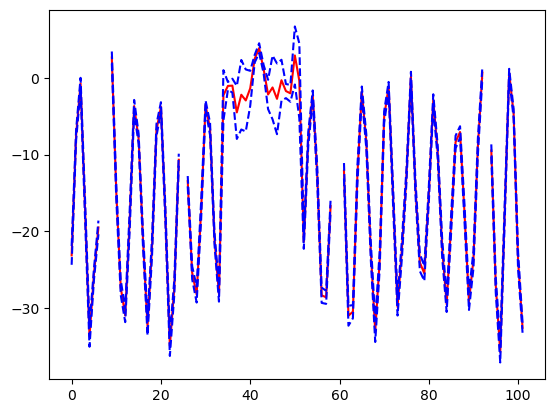

In [282]:
plt.plot(ak.mean(bpm_dict[selected_ts[0]].hor_turn_position, axis=1), color = 'r')
plt.plot(ak.std(bpm_dict[selected_ts[0]].hor_turn_position, axis=1) + ak.mean(bpm_dict[selected_ts[0]].hor_turn_position, axis=1), color = 'b', ls = '--')
plt.plot(-ak.std(bpm_dict[selected_ts[0]].hor_turn_position, axis=1) + ak.mean(bpm_dict[selected_ts[0]].hor_turn_position, axis=1), color='b', ls='--')

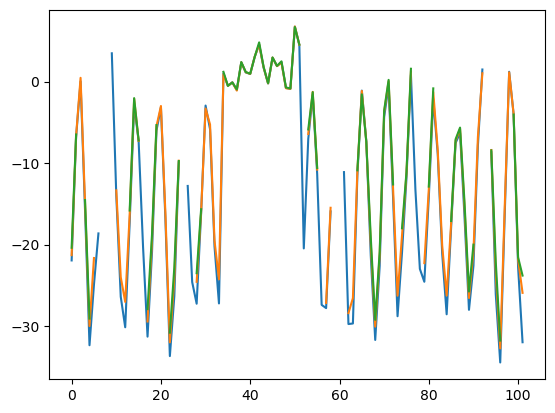

In [ ]:
for ts in selected_ts:
    plt.plot(ak.mean(bpm_dict[ts].hor_turn_position, axis=1))

Mean and std of this bump looks very reproducible

## Mean and std overview

In [20]:
means = {}
stds = {}

cases = [0, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20]
c = 0
for ts_start, ts_end in zip(df_params.loc["2025-06-16 20:00:00":"2025-06-16 20:30:00"].index[:-1], df_params.loc["2025-06-16 20:00:00":"2025-06-16 20:30:00"].index[1:]):
    files_case_study = paths_per_ts.loc[ts_start:ts_end-dt, "path"].to_numpy()
    ts_case_study = paths_per_ts.loc[ts_start:ts_end-dt].index.to_numpy()
    bpm_dict_study = {}
    mean_study = []
    std_study = []

    for i, path in enumerate(files_case_study):
        bpm_dict_study[ts_case_study[i]] = ak.Array(ak.from_parquet(path), with_name="BPMCollection")
        mean_study.append(ak.nanmean(bpm_dict_study[ts_case_study[i]].hor_turn_position, axis=1))
        std_study.append(ak.nanstd(bpm_dict_study[ts_case_study[i]].hor_turn_position, axis=1))
    mean_study = ak.Array(mean_study)
    std_study = ak.Array(std_study)

    means[cases[c]] = ak.nanmean(mean_study, axis=0)
    stds[cases[c]] = ak.nanmean(std_study, axis=0)
    c += 1
    

In [21]:
def get_y_extent_vlines(means, stds, cases):
    max_vals = []
    min_vals = []
    for case in cases:
        if case != 0:
            max_vals.append(ak.nanmax(means[case] + stds[case]))
            min_vals.append(ak.nanmin(means[case] - stds[case]))
    return ak.max(max_vals), ak.min(min_vals)

/var/folders/b5/swvf1qzj6l36gcd1zzs4_g8h0000gn/T/ipykernel_933/3773710161.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('inferno')  # Alternatives: "cividis", "viridis", "inferno", "turbo"


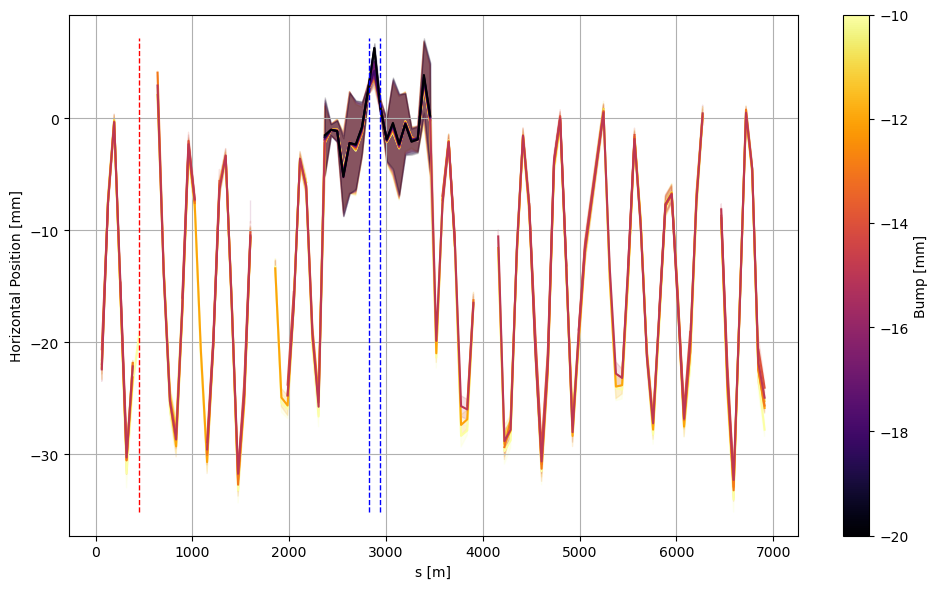

In [22]:
# Choose a perceptually uniform colormap
cmap = get_cmap('inferno')  # Alternatives: "cividis", "viridis", "inferno", "turbo"

# Assume 'cases' are the bump values in mm (like [1, 2, 3])
bump_values = [case for i, case in enumerate(cases) if i > 0]

# Normalize based on bump values
norm = mcolors.Normalize(vmin=min(bump_values), vmax=max(bump_values))

fig, ax = plt.subplots(figsize=(10, 6))

for i, case in enumerate(cases):
    if i> 0 :
        color = cmap(norm(case))
        y = ak.to_numpy(means[case])
        err = ak.to_numpy(stds[case])
        ax.plot(s_pos, y, label=f"Bump {case} mm", color=color)
        ax.fill_between(s_pos, y - err, y + err, alpha=0.15, color=color)

max_val, min_val = get_y_extent_vlines(means, stds, cases)
ax.vlines(s_tidp, min_val, max_val, 
                color='r', lw=1, ls='--')
ax.vlines(np.min(tt.rows['.*act.*'].s_start),
                min_val, max_val, 
                color='b', lw=1, ls='--')
ax.vlines(np.max(tt.rows['.*act.*'].s_end),
                min_val, max_val, 
                color='b', lw=1, ls='--')
# Add colorbar that maps bump values to colors
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required in some versions
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Bump [mm]")

ax.set_xlabel("s [m]")
ax.set_ylabel("Horizontal Position [mm]")
#ax.set_title("Effect of Bump on Measurement")
ax.grid(True)

plt.tight_layout()
plt.savefig('gianni_radial_steering_bump_effect.pdf', dpi=300)

# Analysis no tune shift, no bump, chroma variation

In [ ]:
df_params

,radial_steering,'bump,chroma,tune_shift
2025-06-16 11:52:00+02:00,DPpos,0.0,0.5,0.0
2025-06-16 15:05:08+02:00,DPpos,0.0,0.7,0.0
2025-06-16 15:08:38+02:00,DPpos,0.0,1.0,0.0
2025-06-16 15:14:14+02:00,DPneg,0.0,0.5,0.0
2025-06-16 15:18:26+02:00,DPneg,0.0,0.7,0.0
2025-06-16 15:21:56+02:00,DPneg,0.0,1.0,0.0
2025-06-16 15:28:56+02:00,DPneg,0.0,0.4,0.0
2025-06-16 15:35:14+02:00,DPneg,0.005,0.4,0.0
2025-06-16 15:39:26+02:00,DPneg,0.005,0.5,0.0
2025-06-16 16:46:51+02:00,DPneg,0.01,0.5,0.0


## DPpos

In [23]:
means = {}
stds = {}

cases = [0.5, 0.7, 1.0]
c = 0
for ts_start, ts_end in zip(df_params.loc["2025-06-16 11:52:00":"2025-06-16 15:14:14"].index[:-1], df_params.loc["2025-06-16 11:52:00":"2025-06-16 15:14:14"].index[1:]):
    files_case_study = paths_per_ts.loc[ts_start:ts_end-dt, "path"].to_numpy()
    ts_case_study = paths_per_ts.loc[ts_start:ts_end-dt].index.to_numpy()
    bpm_dict_study = {}
    mean_study = []
    std_study = []

    for i, path in enumerate(files_case_study):
        bpm_dict_study[ts_case_study[i]] = ak.Array(ak.from_parquet(path), with_name="BPMCollection")
        mean_study.append(ak.nanmean(bpm_dict_study[ts_case_study[i]].hor_turn_position, axis=1))
        std_study.append(ak.nanstd(bpm_dict_study[ts_case_study[i]].hor_turn_position, axis=1))
    mean_study = ak.Array(mean_study)
    std_study = ak.Array(std_study)

    means[cases[c]] = ak.nanmean(mean_study, axis=0)
    stds[cases[c]] = ak.nanmean(std_study, axis=0)
    c += 1
    

/var/folders/b5/swvf1qzj6l36gcd1zzs4_g8h0000gn/T/ipykernel_933/676926795.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('inferno')  # Alternatives: "cividis", "viridis", "inferno", "turbo"


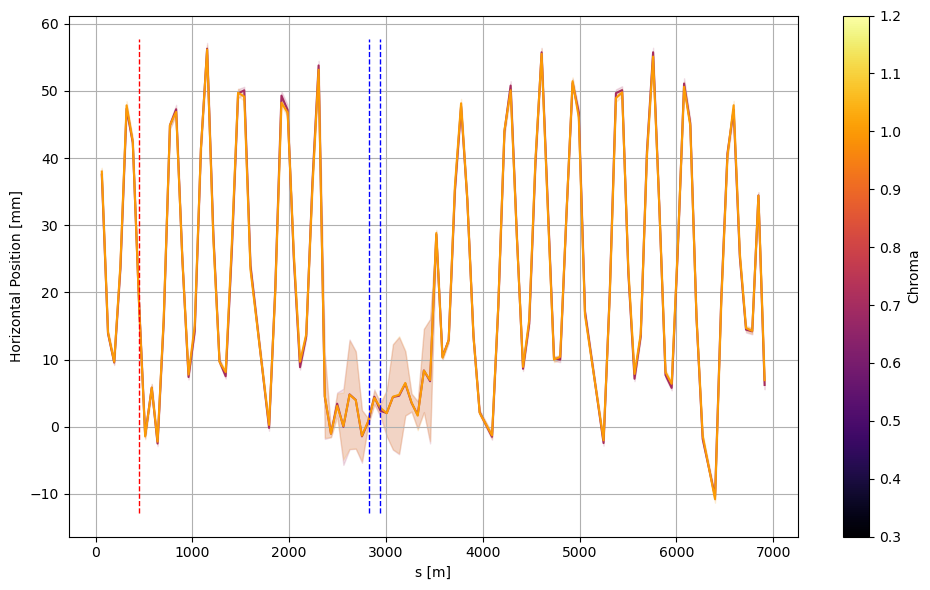

In [24]:
# Choose a perceptually uniform colormap
cmap = get_cmap('inferno')  # Alternatives: "cividis", "viridis", "inferno", "turbo"

# Assume 'cases' are the bump values in mm (like [1, 2, 3])
chroma_vals = [case for case in cases]

# Normalize based on bump values
norm = mcolors.Normalize(vmin=min(chroma_vals)-0.2, vmax=max(chroma_vals)+0.2)

fig, ax = plt.subplots(figsize=(10, 6))

for i, case in enumerate(cases):
    if i> 0 :
        color = cmap(norm(case))
        y = ak.to_numpy(means[case])
        err = ak.to_numpy(stds[case])
        ax.plot(s_pos, y, label=f"Bump {case} mm", color=color)
        ax.fill_between(s_pos, y - err, y + err, alpha=0.15, color=color)

max_val, min_val = get_y_extent_vlines(means, stds, cases)
ax.vlines(s_tidp, min_val, max_val, 
                color='r', lw=1, ls='--')
ax.vlines(np.min(tt.rows['.*act.*'].s_start),
                min_val, max_val, 
                color='b', lw=1, ls='--')
ax.vlines(np.max(tt.rows['.*act.*'].s_end),
                min_val, max_val, 
                color='b', lw=1, ls='--')
# Add colorbar that maps bump values to colors
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required in some versions
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Chroma")

ax.set_xlabel("s [m]")
ax.set_ylabel("Horizontal Position [mm]")
#ax.set_title("Effect of Bump on Measurement")
ax.grid(True)

plt.tight_layout()
plt.savefig('DPpos_no_bump_no_tuneshift.pdf', dpi=300)

## DPneg

In [25]:
means = {}
stds = {}

cases = [0.5, 0.7, 1.0, 0.4]
c = 0
for ts_start, ts_end in zip(df_params.loc["2025-06-16 15:14:14":"2025-06-16 15:35:14"].index[:-1], df_params.loc["2025-06-16 15:14:14":"2025-06-16 15:35:14"].index[1:]):
    files_case_study = paths_per_ts.loc[ts_start:ts_end-dt, "path"].to_numpy()
    ts_case_study = paths_per_ts.loc[ts_start:ts_end-dt].index.to_numpy()
    bpm_dict_study = {}
    mean_study = []
    std_study = []

    for i, path in enumerate(files_case_study):
        bpm_dict_study[ts_case_study[i]] = ak.Array(ak.from_parquet(path), with_name="BPMCollection")
        mean_study.append(ak.nanmean(bpm_dict_study[ts_case_study[i]].hor_turn_position, axis=1))
        std_study.append(ak.nanstd(bpm_dict_study[ts_case_study[i]].hor_turn_position, axis=1))
    mean_study = ak.Array(mean_study)
    std_study = ak.Array(std_study)

    means[cases[c]] = ak.nanmean(mean_study, axis=0)
    stds[cases[c]] = ak.nanmean(std_study, axis=0)
    c += 1
    

/var/folders/b5/swvf1qzj6l36gcd1zzs4_g8h0000gn/T/ipykernel_933/3456499589.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('inferno')  # Alternatives: "cividis", "viridis", "inferno", "turbo"


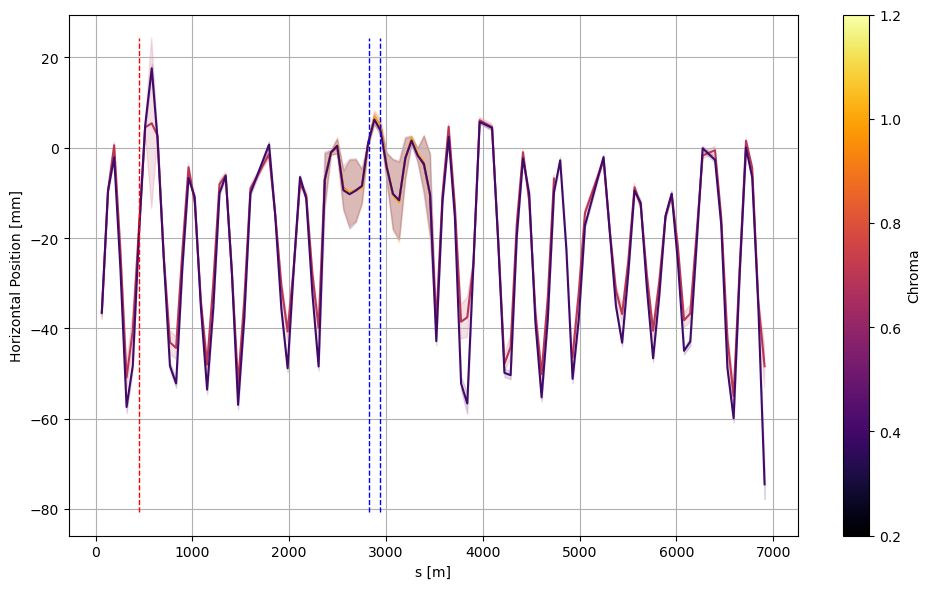

In [26]:
# Choose a perceptually uniform colormap
cmap = get_cmap('inferno')  # Alternatives: "cividis", "viridis", "inferno", "turbo"

# Assume 'cases' are the bump values in mm (like [1, 2, 3])
chroma_vals = [case for case in cases]

# Normalize based on bump values
norm = mcolors.Normalize(vmin=min(chroma_vals)-0.2, vmax=max(chroma_vals)+0.2)

fig, ax = plt.subplots(figsize=(10, 6))

for i, case in enumerate(cases):
    if i> 0 :
        color = cmap(norm(case))
        y = ak.to_numpy(means[case])
        err = ak.to_numpy(stds[case])
        ax.plot(s_pos, y, label=f"Bump {case} mm", color=color)
        ax.fill_between(s_pos, y - err, y + err, alpha=0.15, color=color)

max_val, min_val = get_y_extent_vlines(means, stds, cases)
ax.vlines(s_tidp, min_val, max_val, 
                color='r', lw=1, ls='--')
ax.vlines(np.min(tt.rows['.*act.*'].s_start),
                min_val, max_val, 
                color='b', lw=1, ls='--')
ax.vlines(np.max(tt.rows['.*act.*'].s_end),
                min_val, max_val, 
                color='b', lw=1, ls='--')
# Add colorbar that maps bump values to colors
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required in some versions
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Chroma")

ax.set_xlabel("s [m]")
ax.set_ylabel("Horizontal Position [mm]")
#ax.set_title("Effect of Bump on Measurement")
ax.grid(True)

plt.tight_layout()
plt.savefig('DPneg_no_bump_no_tuneshift.pdf', dpi=300)